In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


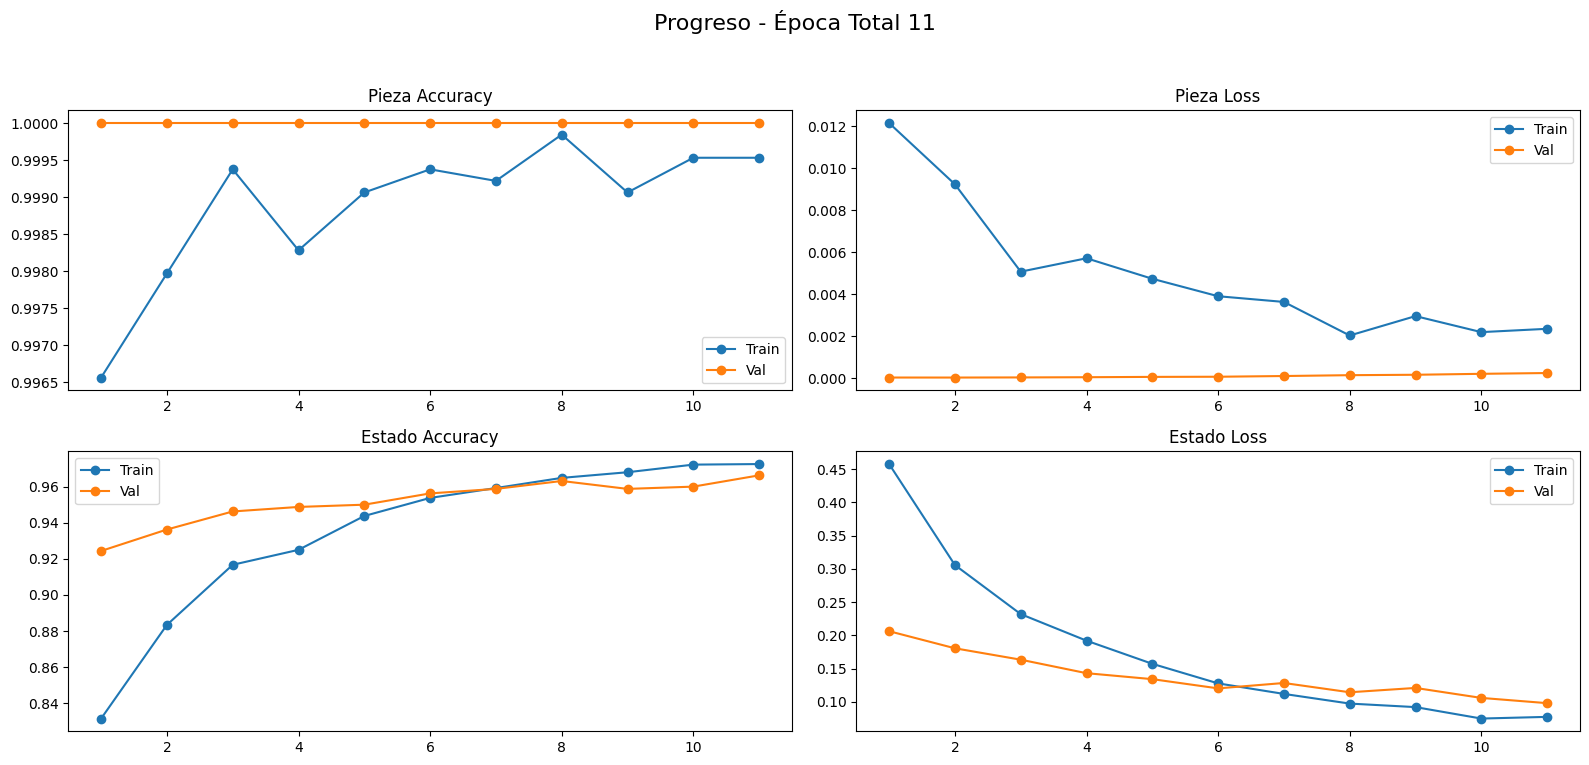

200/200 ━━━━━━━━━━━━━━━━━━━━ 139s 669ms/step - loss: 0.0841 - output_estado_accuracy: 0.9708 - output_estado_loss: 0.0815 - output_pieza_accuracy: 0.9994 - output_pieza_loss: 0.0026 - val_loss: 0.0983 - val_output_estado_accuracy: 0.9663 - val_output_estado_loss: 0.0980 - val_output_pieza_accuracy: 1.0000 - val_output_pieza_loss: 2.3926e-04
Ajuste fino finalizado.

--- FASE 8: GUARDANDO ARTEFACTOS FINALES ---
-> Modelo guardado en: 'modelo_diagnostico_v1.keras'
-> Traductor de piezas guardado en: 'pieza_encoder.joblib'
-> Traductor de estados guardado en: 'estado_encoder.joblib'

¡PROCESO COMPLETADO! Tienes los 3 artefactos necesarios para el backend.


In [2]:
# ===================================================================
# PASO 1: CONFIGURACIÓN Y CARGA DE DATOS
# ===================================================================
print("\n--- FASE 1: CONFIGURACIÓN Y CARGA DE DATOS ---")

# La ruta es relativa a la carpeta "Taller_IA" donde se ejecuta el notebook.
dataset_path = "Dataset"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

if not os.path.exists(dataset_path):
    raise RuntimeError(f"¡Error Crítico! No se encontró la carpeta del dataset en: '{os.path.abspath(dataset_path)}'")

# Catalogamos las imágenes, ignorando directorios ocultos.
image_catalog = []
tipos_de_pieza = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')])
todos_los_estados = set()

for pieza in tipos_de_pieza:
    path_pieza = os.path.join(dataset_path, pieza)
    estados_de_pieza = sorted([s for s in os.listdir(path_pieza) if os.path.isdir(os.path.join(path_pieza, s)) and not s.startswith('.')])
    for estado in estados_de_pieza:
        todos_los_estados.add(estado)
        path_estado = os.path.join(path_pieza, estado)
        imagenes = [f for f in os.listdir(path_estado) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for imagen_nombre in imagenes:
            image_path = os.path.join(path_estado, imagen_nombre)
            image_catalog.append({'path': image_path, 'pieza': pieza, 'estado': estado})

todos_los_estados = sorted(list(todos_los_estados))
print(f"Catalogación completa. Total de imágenes: {len(image_catalog)}")
print(f"Tipos de pieza encontrados: {tipos_de_pieza}")
print(f"Todos los estados posibles encontrados: {todos_los_estados}")

# ===================================================================
# PASO 2: CODIFICACIÓN Y DIVISIÓN DE DATOS
# ===================================================================
print("\n--- FASE 2: CODIFICANDO Y DIVIDIENDO DATOS ---")

image_paths = [item['path'] for item in image_catalog]
pieza_labels_str = [item['pieza'] for item in image_catalog]
estado_labels_str = [item['estado'] for item in image_catalog]

# Codificador para las PIEZAS
pieza_encoder = LabelEncoder()
pieza_encoded = pieza_encoder.fit_transform(pieza_labels_str)
pieza_onehot = tf.keras.utils.to_categorical(pieza_encoded, num_classes=len(tipos_de_pieza))

# Codificador para los ESTADOS
estado_encoder = LabelEncoder()
estado_encoder.fit(todos_los_estados)
estado_encoded = estado_encoder.transform(estado_labels_str)
estado_onehot = tf.keras.utils.to_categorical(estado_encoded, num_classes=len(todos_los_estados))

# División del dataset
X_train, X_val, y_train_pieza, y_val_pieza, y_train_estado, y_val_estado = train_test_split(
    image_paths, pieza_onehot, estado_onehot, test_size=0.2, random_state=42, stratify=np.array(pieza_labels_str)
)
print(f"Dataset dividido: {len(X_train)} para entrenamiento, {len(X_val)} para validación.")

# ===================================================================
# PASO 3: CREACIÓN DE PIPELINES DE DATOS (tf.data)
# ===================================================================
print("\n--- FASE 3: CONSTRUYENDO PIPELINES DE DATOS ---")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img

def configure_dataset(paths, pieza_labels, estado_labels, augment=False):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    img_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices({"output_pieza": pieza_labels, "output_estado": estado_labels})
    ds = tf.data.Dataset.zip((img_ds, labels_ds))
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = configure_dataset(X_train, y_train_pieza, y_train_estado, augment=True)
val_ds = configure_dataset(X_val, y_val_pieza, y_val_estado)
print("Pipelines de datos listos.")

# ===================================================================
# PASO 4: CONSTRUCCIÓN DEL MODELO
# ===================================================================
print("\n--- FASE 4: CONSTRUYENDO ARQUITECTURA DEL MODELO ---")

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_pieza = tf.keras.layers.Dense(len(tipos_de_pieza), activation='softmax', name='output_pieza')(x)
output_estado = tf.keras.layers.Dense(len(todos_los_estados), activation='softmax', name='output_estado')(x)
model = tf.keras.Model(inputs, [output_pieza, output_estado])

model.summary()

# ===================================================================
# PASO 5: CALLBACK PARA VISUALIZACIÓN EN VIVO
# ===================================================================
# Esta clase es la responsable de generar las gráficas y estadísticas
# en tiempo real durante el entrenamiento.
class LivePlotCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None): self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}; self.model.history.history.setdefault('total_epochs', []).append(epoch)
        for k, v in logs.items(): self.history.setdefault(k, []).append(v)
        clear_output(wait=True)
        total_epochs = len(self.history.get('loss', []))
        epochs_range = range(1, total_epochs + 1)
        if not total_epochs: return
        plt.figure(figsize=(16, 8)); plt.suptitle(f'Progreso - Época Total {total_epochs}', fontsize=16)
        plt.subplot(2, 2, 1); plt.plot(epochs_range, self.history.get('output_pieza_accuracy', []), 'o-', label='Train'); plt.plot(epochs_range, self.history.get('val_output_pieza_accuracy', []), 'o-', label='Val'); plt.legend(); plt.title('Pieza Accuracy')
        plt.subplot(2, 2, 2); plt.plot(epochs_range, self.history.get('output_pieza_loss', []), 'o-', label='Train'); plt.plot(epochs_range, self.history.get('val_output_pieza_loss', []), 'o-', label='Val'); plt.legend(); plt.title('Pieza Loss')
        plt.subplot(2, 2, 3); plt.plot(epochs_range, self.history.get('output_estado_accuracy', []), 'o-', label='Train'); plt.plot(epochs_range, self.history.get('val_output_estado_accuracy', []), 'o-', label='Val'); plt.legend(); plt.title('Estado Accuracy')
        plt.subplot(2, 2, 4); plt.plot(epochs_range, self.history.get('output_estado_loss', []), 'o-', label='Train'); plt.plot(epochs_range, self.history.get('val_output_estado_loss', []), 'o-', label='Val'); plt.legend(); plt.title('Estado Loss')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

live_plot_callback = LivePlotCallback()

# ===================================================================
# PASO 6: ENTRENAMIENTO FASE 1 (TRANSFER LEARNING)
# ===================================================================
print("\n--- FASE 6: ENTRENAMIENTO DE LA CABEZA (TRANSFER LEARNING) ---")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss={"output_pieza": "categorical_crossentropy", "output_estado": "categorical_crossentropy"}, 
              metrics={"output_pieza": "accuracy", "output_estado": "accuracy"})

initial_epochs = 15 # Podemos usar menos épocas para la cabeza
history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds, callbacks=[live_plot_callback])
print("Entrenamiento de la cabeza finalizado.")

# ===================================================================
# PASO 7: ENTRENAMIENTO FASE 2 (AJUSTE FINO)
# ===================================================================
print("\n--- FASE 7: AJUSTE FINO (FINE-TUNING) ---")

base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Tasa de aprendizaje muy baja
              loss={"output_pieza": "categorical_crossentropy", "output_estado": "categorical_crossentropy"}, 
              metrics={"output_pieza": "accuracy", "output_estado": "accuracy"})

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(train_ds,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1], # Continuamos desde la última época
                              validation_data=val_ds,
                              callbacks=[live_plot_callback])
print("Ajuste fino finalizado.")

# ===================================================================
# PASO 8: GUARDADO FINAL DE ARTEFACTOS
# ===================================================================
print("\n--- FASE 8: GUARDANDO ARTEFACTOS FINALES ---")

# Guardamos el modelo final
model_filename = "modelo_diagnostico_v1.keras"
model.save(model_filename)
print(f"-> Modelo guardado en: '{model_filename}'")

# Guardamos los codificadores de etiquetas (traductores)
pieza_encoder_filename = "pieza_encoder.joblib"
estado_encoder_filename = "estado_encoder.joblib"
joblib.dump(pieza_encoder, pieza_encoder_filename)
joblib.dump(estado_encoder, estado_encoder_filename)
print(f"-> Traductor de piezas guardado en: '{pieza_encoder_filename}'")
print(f"-> Traductor de estados guardado en: '{estado_encoder_filename}'")

print("\n¡PROCESO COMPLETADO! Tienes los 3 artefactos necesarios para el backend.")